In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
#import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Conv2D, MaxPooling2D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def add_layer(tensor):
    return tensor[0] + tensor[1]

def mul_layer(tensor):
    return tensor[0] * tensor[1]

def div_layer(tensor):
    return tensor[0] / tensor[1]

def sub_layer(tensor):
    return tensor[0] - tensor[1]

def neg_layer(tensor):
    return -tensor

def cos_layer(tensor):
    return tf.math.cos(tensor)

def sin_layer(tensor):
    return tf.math.sin(tensor)

# Model

In [3]:
# feature extraction from left image
left_img = Input(shape = (112,112,3), name="left_image")

# feature extraction from right image
right_img = Input(shape = (112,112,3), name="right_image")

left_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=left_img, input_shape=(112,112,3))
left_phi_features = left_phi_model.output
left_flat = Flatten(name='left-phi-flattened')(left_phi_features)

right_phi_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=right_img, input_shape=(112,112,3))
right_phi_features = right_phi_model.output
right_flat = Flatten(name='right-phi-flattened')(right_phi_features)

concat = concatenate([left_flat, right_flat])

# fx
dense_1 = Dense(120, activation = 'relu')(concat)
dense_2 = Dense(84, activation = 'relu')(dense_1)
pred_fx = Dense(1, name='fx')(dense_2)

# fy
dense_3 = Dense(120, activation = 'relu')(concat)
dense_4 = Dense(84, activation = 'relu')(dense_3)
pred_fy = Dense(1, name='fy')(dense_4)

# u0
dense_5 = Dense(120, activation = 'relu')(concat)
dense_6 = Dense(84, activation = 'relu')(dense_5)
pred_u0 = Dense(1, name='u0')(dense_6)

# v0
dense_7 = Dense(120, activation = 'relu')(concat)
dense_8 = Dense(84, activation = 'relu')(dense_7)
pred_v0 = Dense(1, name='v0')(dense_8)

# baseline
dense_9 = Dense(120, activation = 'relu')(concat)
dense_10 = Dense(84, activation = 'relu')(dense_9)
pred_baseline = Dense(1, name='baseline')(dense_10)

# tx
dense_11 = Dense(120, activation = 'relu')(concat)
dense_12 = Dense(84, activation = 'relu')(dense_11)
pred_x = Dense(1, name='x')(dense_12)

# ty
dense_13 = Dense(120, activation = 'relu')(concat)
dense_14 = Dense(84, activation = 'relu')(dense_13)
pred_y = Dense(1, name='y')(dense_14)

# tz
dense_15 = Dense(120, activation = 'relu')(concat)
dense_16 = Dense(84, activation = 'relu')(dense_15)
pred_z = Dense(1, name='z')(dense_16)

# pitch
dense_17 = Dense(120, activation = 'relu')(concat)
dense_18 = Dense(84, activation = 'relu')(dense_17)
pred_pitch = Dense(1, name='pitch')(dense_18)

# u
dense_19 = Dense(120, activation = 'relu')(concat)
dense_20 = Dense(84, activation = 'relu')(dense_19)
pred_u = Dense(1, name='u')(dense_20)

# v
dense_21 = Dense(120, activation = 'relu')(concat)
dense_22 = Dense(84, activation = 'relu')(dense_21)
pred_v = Dense(1, name='v')(dense_22)

# disparity
dense_23 = Dense(120, activation = 'relu')(concat)
dense_24 = Dense(84, activation = 'relu')(dense_23)
pred_disparity = Dense(1, name='disparity')(dense_24)

# w_xcam
#dense_25 = Dense(120, activation = 'relu')(concat)
#dense_26 = Dense(84, activation = 'relu')(dense_25)
#w_xcam = Dense(1, name='w_xcam', activation = 'sigmoid')(dense_26)

# w_ycam
#dense_27 = Dense(120, activation = 'relu')(concat)
#dense_28 = Dense(84, activation = 'relu')(dense_27)
#w_ycam = Dense(1, name='w_ycam', activation = 'sigmoid')(dense_28)

# w_zcam
#dense_29 = Dense(120, activation = 'relu')(concat)
#dense_30 = Dense(84, activation = 'relu')(dense_29)
#w_zcam = Dense(1, name='w_zcam', activation = 'sigmoid')(dense_30)

# w_xworld
dense_31 = Dense(120, activation = 'relu')(concat)
dense_32 = Dense(84, activation = 'relu')(dense_31)
w_xworld = Dense(1, name='w_xworld', activation = 'sigmoid')(dense_32)

# w_yworld
dense_33 = Dense(120, activation = 'relu')(concat)
dense_34 = Dense(84, activation = 'relu')(dense_33)
w_yworld = Dense(1, name='w_yworld', activation = 'sigmoid')(dense_34)

# w_zworld
dense_35 = Dense(120, activation = 'relu')(concat)
dense_36 = Dense(84, activation = 'relu')(dense_35)
w_zworld = Dense(1, name='w_zworld', activation = 'sigmoid')(dense_36)


# xCam = (self.intrinsic.fx * self.extrinsic.baseline) / disparity
mul_1 = Lambda(mul_layer)([pred_fx, pred_baseline])
xCam = Lambda(div_layer)([mul_1, pred_disparity])
#xCam = Lambda(mul_layer, name='xCam')([xCam, w_xcam])

# yCam = - (xCam / self.intrinsic.fx) * (u - self.intrinsic.u0)
div_1 = Lambda(div_layer)([xCam, pred_fx])
sub_1 = Lambda(sub_layer)([pred_u, pred_u0])
yCam = Lambda(mul_layer)([Lambda(neg_layer)(div_1), sub_1])
#yCam = Lambda(mul_layer, name='yCam')([yCam, w_ycam])

# zCam = (xCam / self.intrinsic.fy) * (self.intrinsic.v0 - v)
div_2 = Lambda(div_layer)([xCam, pred_fy])
sub_2 = Lambda(sub_layer)([pred_v0, pred_v])
zCam = Lambda(mul_layer)([div_2, sub_2])
#zCam = Lambda(mul_layer, name='zCam')([zCam, w_zcam])

# Y = yCam + self.extrinsic.y
pred_yWorld = Lambda(add_layer)([yCam, pred_y])
pred_yWorld = Lambda(mul_layer, name='yWorld')([pred_yWorld, w_yworld])

# X = xCam * math.cos(self.extrinsic.pitch) + zCam * math.sin(self.extrinsic.pitch) + self.extrinsic.x
mul_2 = Lambda(mul_layer)([xCam, Lambda(cos_layer)(pred_pitch)])
mul_3 = Lambda(mul_layer)([zCam, Lambda(sin_layer)(pred_pitch)])
add_1 = Lambda(add_layer)([mul_2, mul_3])
pred_xWorld = Lambda(add_layer)([add_1, pred_x])
pred_xWorld = Lambda(mul_layer, name='xWorld')([pred_xWorld, w_xworld])

# Z = - xCam * math.sin(self.extrinsic.pitch) + zCam * math.cos(self.extrinsic.pitch) + self.extrinsic.z
mul_4 = Lambda(mul_layer)([Lambda(neg_layer)(xCam), Lambda(sin_layer)(pred_pitch)])
mul_5 = Lambda(mul_layer)([zCam, Lambda(cos_layer)(pred_pitch)])
add_2 = Lambda(add_layer)([mul_4, mul_5])
pred_zWorld = Lambda(add_layer)([add_2, pred_z])
pred_zWorld = Lambda(mul_layer, name='zWorld')([pred_zWorld, w_zworld])

# create model
model = Model(inputs=[left_img, right_img], outputs=[pred_fx, pred_fy, pred_u0, pred_v0, pred_baseline, pred_disparity, pred_x, pred_y, pred_z, pred_pitch, pred_xWorld,pred_yWorld,pred_zWorld])

# set output types
target1 = tf.placeholder(dtype='float32', shape=(1,1)) 
target2 = tf.placeholder(dtype='float32', shape=(1,1))
target3 = tf.placeholder(dtype='float32', shape=(1,1))
target4 = tf.placeholder(dtype='float32', shape=(1,1)) 
target5 = tf.placeholder(dtype='float32', shape=(1,1))
target6 = tf.placeholder(dtype='float32', shape=(1,1))
target7 = tf.placeholder(dtype='float32', shape=(1,1)) 
target8 = tf.placeholder(dtype='float32', shape=(1,1))
target9 = tf.placeholder(dtype='float32', shape=(1,1))
target10 = tf.placeholder(dtype='float32', shape=(1,1)) 
target11 = tf.placeholder(dtype='float32', shape=(1,1))
target12 = tf.placeholder(dtype='float32', shape=(1,1))
target13 = tf.placeholder(dtype='float32', shape=(1,1))

# get model summary
model.summary()

learning_rate = 0.001

# compile model
model.compile(loss="mae", target_tensors=[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13],optimizer=optimizers.Adam(lr=learning_rate))
#plot_model(model, to_file='model.png')


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_image (InputLayer)         [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
right_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 55, 55, 32)   864         left_image[0][0]                 
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 55, 55, 32)   864         right_image[0][0]                
_______________________________________________________________________________________

# Get data

In [4]:
data_path = "../Data/"

Left_images = np.load(data_path+"li.npy")
Right_images = np.load(data_path+"ri.npy")
Fx = np.load(data_path+"fx.npy")
Fy = np.load(data_path+"fy.npy") 
U0 = np.load(data_path+"u0.npy") 
V0 = np.load(data_path+"v0.npy") 
Baseline = np.load(data_path+"b.npy")
Disparity = np.load(data_path+"d.npy") 
Tx = np.load(data_path+"tx.npy") 
Ty = np.load(data_path+"ty.npy") 
Tz = np.load(data_path+"tz.npy") 
Pitch = np.load(data_path+"p.npy")
X = np.load(data_path+"x.npy")
Y = np.load(data_path+"y.npy") 
Z = np.load(data_path+"z.npy")


In [5]:
print ("dataset: ",np.shape(Z))

dataset:  (123017,)


In [6]:
print ("Training Dataset: ",len(Left_images)*0.7, "Test Dataset: ", len(Left_images)*0.3)

Training Dataset:  86111.9 Test Dataset:  36905.1


In [7]:
import os
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
#from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

model_name = 'model_multi_class/'
SAVE = "new_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
# Save
output_folder = SAVE + model_name
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_log = output_folder + "Log/"
if not os.path.exists(output_log):
    os.makedirs(output_log)

output_weight = output_folder + "Best/"
if not os.path.exists(output_weight):
    os.makedirs(output_weight)


input_shape = (112, 112, 3)

tensorboard = TensorBoard(log_dir=output_log)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)

csv_logger = CSVLogger('training.log')

checkpointer = tf.keras.callbacks.ModelCheckpoint(
    filepath=output_weight + "weights_{epoch:02d}_{val_loss:.2f}.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True
)

history = model.fit(
    x=[Left_images[:int(len(Left_images)*0.7)], Right_images[:int(len(Left_images)*0.7)]],
    y=[Fx[:int(len(Left_images)*0.7)], Fy[:int(len(Left_images)*0.7)], U0[:int(len(Left_images)*0.7)], V0[:int(len(Left_images)*0.7)], Baseline[:int(len(Left_images)*0.7)], Disparity[:int(len(Left_images)*0.7)], Tx[:int(len(Left_images)*0.7)], Ty[:int(len(Left_images)*0.7)], Tz[:int(len(Left_images)*0.7)], Pitch[:int(len(Left_images)*0.7)], X[:int(len(Left_images)*0.7)], Y[:int(len(Left_images)*0.7)], Z[:int(len(Left_images)*0.7)]],
    batch_size=16,
    epochs=200,
    verbose=1,
    shuffle=True,
    initial_epoch=0,
    validation_data=([Left_images[int(len(Left_images)*0.7):], Right_images[int(len(Left_images)*0.7):]], [Fx[int(len(Left_images)*0.7):], Fy[int(len(Left_images)*0.7):], U0[int(len(Left_images)*0.7):], V0[int(len(Left_images)*0.7):], Baseline[int(len(Left_images)*0.7):], Disparity[int(len(Left_images)*0.7):], Tx[int(len(Left_images)*0.7):], Ty[int(len(Left_images)*0.7):], Tz[int(len(Left_images)*0.7):], Pitch[int(len(Left_images)*0.7):], X[int(len(Left_images)*0.7):], Y[int(len(Left_images)*0.7):], Z[int(len(Left_images)*0.7):]]),
    callbacks=[tensorboard, checkpointer, early_stopping, csv_logger]
)

Using TensorFlow backend.


Train on 86111 samples, validate on 36906 samples
Epoch 1/200
86111/86111 [==============================] - ETA: 0s - loss: 905.6765 - fx_loss: 3.8065 - fy_loss: 3.6445 - u0_loss: 1.7051 - v0_loss: 1.7613 - baseline_loss: 10.6807 - disparity_loss: 2.0458 - x_loss: 10.5804 - y_loss: 0.3243 - z_loss: 0.3637 - pitch_loss: 3.8337 - xWorld_loss: 386.7510 - yWorld_loss: 2.8712 - zWorld_loss: 477.3048WARNING:tensorflow:From /home/talha/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
86111/86111 [==============================] - 2070s 24ms/sample - loss: 905.6765 - fx_loss: 3.8065 - fy_loss: 3.6445 - u0_loss: 1.7051 - v0_loss: 1.7613 - baseline_loss: 10.6807 - disparity_loss: 2.0458 - x_loss: 10.5804 - y_loss: 0.324

Epoch 12/200
86111/86111 [==============================] - 1982s 23ms/sample - loss: 872.2256 - fx_loss: 0.3548 - fy_loss: 0.3372 - u0_loss: 0.1426 - v0_loss: 0.1431 - baseline_loss: 1.2829 - disparity_loss: 1.4705 - x_loss: 1.1692 - y_loss: 0.0278 - z_loss: 0.0388 - pitch_loss: 0.3610 - xWorld_loss: 386.7469 - yWorld_loss: 2.8551 - zWorld_loss: 477.3015 - val_loss: 734.3215 - val_fx_loss: 0.7274 - val_fy_loss: 1.2506 - val_u0_loss: 0.6113 - val_v0_loss: 0.7684 - val_baseline_loss: 2.0802 - val_disparity_loss: 1.5279 - val_x_loss: 1.8876 - val_y_loss: 0.0410 - val_z_loss: 0.0379 - val_pitch_loss: 0.5649 - val_xWorld_loss: 294.8850 - val_yWorld_loss: 2.8594 - val_zWorld_loss: 427.0713
Epoch 13/200
86111/86111 [==============================] - 1621s 19ms/sample - loss: 871.8306 - fx_loss: 0.3340 - fy_loss: 0.3147 - u0_loss: 0.1347 - v0_loss: 0.1389 - baseline_loss: 1.1291 - disparity_loss: 1.4452 - x_loss: 1.0442 - y_loss: 0.0272 - z_loss: 0.0353 - pitch_loss: 0.3295 - xWorld_loss: 386

Epoch 00023: early stopping


In [7]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
#from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20221213-115858/model_multi_class/Best/weights_18_730.46.h5')



input_shape = (112, 112, 3)


output = model.predict(
    x=[Left_images[int(len(Left_images)*0.7):], Right_images[int(len(Left_images)*0.7):]],
    batch_size=16,
    verbose=1
)


Using TensorFlow backend.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [8]:
np.shape(output)

(13, 23796, 1)

Text(0, 0.5, '% Correct')

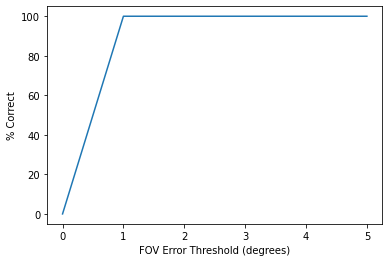

In [8]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 86111

for i  in range(np.shape(output)[1]):
    
    predicted_fov = 2*np.arctan(112/(2*output[0][i][0]))
    actual_fov = 2*np.arctan(112/(2*Fx[k]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[1]*100)
percent_correct.append(th_1/np.shape(output)[1]*100)
percent_correct.append(th_2/np.shape(output)[1]*100)
percent_correct.append(th_3/np.shape(output)[1]*100)
percent_correct.append(th_4/np.shape(output)[1]*100)
percent_correct.append(th_5/np.shape(output)[1]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [9]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 36906, 36906, 36906, 36906, 36906)

In [10]:
th_0/np.shape(output)[1], th_1/np.shape(output)[1], th_2/np.shape(output)[1], th_3/np.shape(output)[1]

(0.0, 1.0, 1.0, 1.0)

In [6]:
np.save("../Data/p_cpla_gd.npy",output)

In [11]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 86111

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.3478343571739174, 'fy': 0.19189420073014976, 'u0': 0.43300600495821917, 'v0': 0.6348261070633906, 'baseline': 1.1611471055641294, 'disparity': 1.3288597947868626, 'x': 1.1601958515207624, 'y': 0.040888431739161596, 'z': 0.029031035155810635, 'pitch': 0.3042366012518227, 'xworld': 294.87614731063985, 'yworld': 2.8593453638974693, 'zworld': 427.08907983415}


In [15]:
max(output[0])[0]

1124.5992

# Normalization

In [6]:

import math 

def normalize(x):
    
    return (math.atan(x) + 3.14/2) / 3.14

In [7]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += normalize(abs(predicted_fx - actual_fx))
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += normalize(abs(predicted_fy - actual_fy))
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += normalize(abs(predicted_u0 - actual_u0))
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += normalize(abs(predicted_v0 - actual_v0))
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += normalize(abs(predicted_baseline - actual_baseline))
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += normalize(abs(predicted_disparity - actual_disparity))
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += normalize(abs(predicted_tx - actual_tx))
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += normalize(abs(predicted_ty - actual_ty))
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += normalize(abs(predicted_tz - actual_tz))
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += normalize(abs(predicted_pitch - actual_pitch))
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += normalize(abs(predicted_x - actual_x))
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += normalize(abs(predicted_y - actual_y))
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += normalize(abs(predicted_z - actual_z))
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.684497496430667, 'fy': 0.6713817717857442, 'u0': 0.5705035358475947, 'v0': 0.6118069484633926, 'baseline': 0.5626533126677936, 'disparity': 0.5113574002642848, 'x': 0.5665639359234423, 'y': 0.5831061090361146, 'z': 0.5675817035001748, 'pitch': 0.7123594741106813, 'xworld': 0.9745200899244825, 'yworld': 0.9819812579767454, 'zworld': 0.9770998745414592}


# Range Normalization

In [6]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

min_fx = 1.9073486e-06
max_fx = 3214.9907

min_fy = 2.9563904e-05
max_fy = 2051.209

min_u0 = 1.9073486e-05
max_u0 = 2178.9983

min_v0 = 3.8146973e-06
max_v0 = 2385.7239

min_baseline = 4.7683716e-06
max_baseline = 22.68721567997021

min_disparity = 9.536743e-07
max_disparity = 134.60031

min_tx = 2.384185791015625e-06
max_tx = 22.68721567997021

min_ty = 2.3841858e-07
max_ty = 33.11693576309983

min_tz = 2.3841858e-06
max_tz = 17.20185265614626

min_pitch = 4.57763671875e-05
max_pitch = 4502.9224

min_xw = 5.219264654243716e-06
max_xw = 386.4486

min_yw = 3.8146973e-06
max_yw = 1835.1849

min_zw = 0.00011349
max_zw = 339.17166

key_counter = 0

for i in error.keys():
    
    k = 55524

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += (abs(predicted_fx - actual_fx) - min_fx)/(max_fx - min_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += (abs(predicted_fy - actual_fy) - min_fy)/(max_fy - min_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += (abs(predicted_u0 - actual_u0) - min_u0)/(max_u0 - min_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += (abs(predicted_v0 - actual_v0) - min_v0)/(max_v0 - min_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += (abs(predicted_baseline - actual_baseline) - min_baseline)/(max_baseline - min_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += (abs(predicted_disparity - actual_disparity) - min_disparity)/(max_disparity - min_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += (abs(predicted_tx - actual_tx) - min_tx)/(max_tx - min_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += (abs(predicted_ty - actual_ty) - min_ty)/(max_ty - min_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += (abs(predicted_tz - actual_tz) - min_tz)/(max_tz - min_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += (abs(predicted_pitch - actual_pitch) - min_pitch)/(max_pitch - min_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += (abs(predicted_x - actual_x) - min_xw)/(max_xw - min_xw)
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += (abs(predicted_y - actual_y) - min_yw)/(max_yw - min_yw)
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += (abs(predicted_z - actual_z) - min_zw)/(max_zw - min_zw)
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.0006045328123734624, 'fy': 0.000916591329541554, 'u0': 0.00010536181074296743, 'v0': 0.00015748116198789617, 'baseline': 0.012927798122878219, 'disparity': 0.0002999877035648339, 'x': 0.01343350695203612, 'y': 0.011566271694155127, 'z': 0.016303638032724194, 'pitch': 0.0003199657518740856, 'xworld': 0.08180485648251173, 'yworld': 0.01367320664940879, 'zworld': 0.12592455279078085}


# Normalized MAE

In [12]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 59.32098482132037

mean_fy = 59.32098482132037

mean_u0 = 56.0

mean_v0 = 56.0

mean_baseline = -84.00701782907929

mean_disparity = -10.972388226877689

mean_tx = -84.00701782907929

mean_ty = 0.4372459762640221

mean_tz = -0.5766162683574485

mean_pitch = -12.380371755270145

mean_xw = -91.94288567681566

mean_yw = 0.4372459762640221

mean_zw = 44.48843272766856



key_counter = 0

for i in error.keys():
    
    k = 86111

    for j  in range(np.shape(output)[1]):
        
        if key_counter == 0: 
    
            predicted_fx = output[key_counter][j][0]
            actual_fx = Fx[k]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            predicted_fy = output[key_counter][j][0]
            actual_fy = Fy[k]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[key_counter][j][0]
            actual_u0 = U0[k]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[key_counter][j][0]
            actual_v0 = V0[k]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[key_counter][j][0]
            actual_baseline = Baseline[k]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[key_counter][j][0]
            actual_disparity = Disparity[k]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[key_counter][j][0]
            actual_tx = Tx[k]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[key_counter][j][0]
            actual_ty = Ty[k]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[key_counter][j][0]
            actual_tz = Tz[k]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[key_counter][j][0]
            actual_pitch = Pitch[k]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[key_counter][j][0]
            actual_x = X[k]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[key_counter][j][0]
            actual_y = Y[k]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[key_counter][j][0]
            actual_z = Z[k]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[1]
    
    key_counter += 1

print (error)

{'fx': 0.005863597143939253, 'fy': 0.003234845161592965, 'u0': 0.007732250088539649, 'v0': 0.011336180483274734, 'baseline': -0.013822025058984909, 'disparity': -0.12110944010637019, 'x': -0.013810701552116732, 'y': 0.0935135689264111, 'z': -0.050347235672884974, 'pitch': -0.024574108699305833, 'xworld': -3.207166548449957, 'yworld': 6.539443514904524, 'zworld': 9.60000282429629}


In [13]:
np.shape(output)

(13, 23796, 1)

In [14]:
k

79320

In [18]:
sum(error.values())

401.2137982147371